<a href="https://colab.research.google.com/github/shayansoh/transfer-learning-vgg16-cnn/blob/main/transfer_learning_on_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR10 Classification using Transfer Learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1.0 Importing the Dataset

In [ ]:
transform = transforms.Compose([
                                transforms.Resize(size=(224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize( 
                                    (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261) 
                                    )
])                                

train_dataset = datasets.CIFAR10(
    root= './data', train = True, download =True, 
    transform = transform)

test_dataset = datasets.CIFAR10(
    root= './data', train = False, download =True, 
    transform = transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# preparing train/test loaders and dividing into batches
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size = batch_size, 
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size = batch_size, 
                                          shuffle = True)
n_total_step = len(train_loader)

## 2.0: Loading Pre-Trained VGG16 Model

In [ ]:
# model import and changing to 10 classes
model = models.vgg16(pretrained = True)
model.classifier[6].out_features = 10

# freezing weights since pre-trained
for w in model.features.parameters():
  w.requires_grad = False

# optimizer
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# loss function
loss_fn = nn.CrossEntropyLoss()

## 3.0 Training and Validation Loop

In [ ]:
# training loop
def fit(model, train_loader):
    model.train()
    running_loss = 0
    corr_target = 0
    for i, data in enumerate(train_loader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        corr_target += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = corr_target / len(train_loader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2%}')
    
    return train_loss, train_accuracy

# validation function (no backprop)
def predict(model, test_loader):
    model.eval()
    running_loss = 0.0
    corr_target = 0
    for int, data in enumerate(test_loader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = loss_fn(output, target)
        running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        corr_target += (preds == target).sum().item()
    
    val_loss = running_loss / len(test_loader.dataset)
    val_accuracy = corr_target / len(test_loader.dataset)
    
    return val_loss, (val_accuracy * 100)

In [ ]:
# training step
if torch.cuda.is_available():
    model.cuda()

train_loss , train_acc = [], []
test_loss , test_acc = [], []
epoch = 11
for epoch in tqdm(range(epoch)):
    train_epoch_loss, train_epoch_acc = fit(model, train_loader)
    test_epoch_loss, test_epoch_acc = predict(model, test_loader)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Loss: 0.0229, Train Accuracy: 77.04%


  9%|▉         | 1/11 [05:58<59:48, 358.84s/it]

Train Loss: 0.0122, Train Accuracy: 86.23%


 18%|█▊        | 2/11 [11:57<53:48, 358.71s/it]

Train Loss: 0.0093, Train Accuracy: 89.69%


 27%|██▋       | 3/11 [17:56<47:50, 358.75s/it]

Train Loss: 0.0070, Train Accuracy: 92.08%


 36%|███▋      | 4/11 [23:54<41:51, 358.73s/it]

Train Loss: 0.0052, Train Accuracy: 94.15%


 45%|████▌     | 5/11 [29:53<35:53, 358.83s/it]

Train Loss: 0.0038, Train Accuracy: 95.80%


 55%|█████▍    | 6/11 [35:53<29:56, 359.21s/it]

Train Loss: 0.0027, Train Accuracy: 97.22%


 64%|██████▎   | 7/11 [41:52<23:56, 359.08s/it]

Train Loss: 0.0019, Train Accuracy: 98.06%


 73%|███████▎  | 8/11 [47:50<17:56, 358.74s/it]

Train Loss: 0.0013, Train Accuracy: 98.74%


 82%|████████▏ | 9/11 [53:47<11:56, 358.21s/it]

Train Loss: 0.0011, Train Accuracy: 99.02%


 91%|█████████ | 10/11 [59:44<05:57, 357.92s/it]

Train Loss: 0.0008, Train Accuracy: 99.35%


100%|██████████| 11/11 [1:05:42<00:00, 358.45s/it]


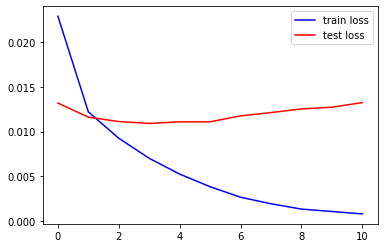

In [ ]:
plt.plot(train_loss, color='b', label='train loss')
plt.plot(test_loss, color='r', label='test loss')
plt.legend()
plt.show()

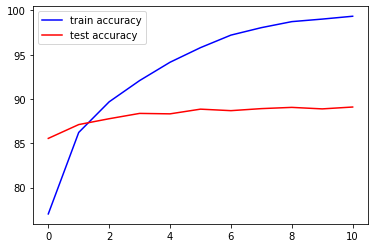

In [ ]:
plt.plot([x * 100 for x in train_acc], color='b', label='train accuracy')
plt.plot(test_acc, color='r', label='test accuracy')
plt.legend()
plt.show()